In [1]:
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

import re
import sys
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from PIL import Image
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import statsmodels.api as sm

mod = sys.modules[__name__]
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

배경지식 ESG

E-환경
S-사회
G-지배구조

ESG이란 원래 사회적인 책임을 지는 기업들의 환경과 사회, 지배구조 등 공공이익을 강조한 특수한 목적을 띄는 요소으로, 
기업이 공공의 이익에 기여함을 강조하는 유럽에서의 장기적인 성장에 중요한 요소로 생각하고 있으며, 
이를 활성화 시키기 장기투자펀드(ELTIF) 확대 및 사회적 기업 활성화 방안 모색을 통해 기업의 ESG 투자 활성화를 꾀함


유럽 공기업을 대상으로한 연구 결과

'Our findings suggest that ESG performance, especially concerning social and governance metrics, 
 meaningfully affects credit ratings.' (Devalle, Alain & Fiandrino, Simona & Cantino Valter, 2017, Conclusion.)
 
재무지표와 ESG 지표를 사용해 분석을 하였고 ESG가 신용평가에 유의미한 영향을 준다는 것으로 결론을 내림

Logistics regression 모델 사용 
   (환경)Env_Innov_Sc - 0.021 

   (사회)Community_Sc - 0.001

   (지배구조)Product_Resp_Sc - 0.037
   (지배구조)Shareholder_Sc - 0.001
 

한국에서의 ESG

신평사들은 ESG를 기업 신용등급에 영향을 주는 주요한 평가 요소로 별도 반영하는 것에는 조심스러운 반응이다

국내 신용평가사는 ESG 일부 요소가 이미 신용등급에 반영돼 있다는 입장이다. 
실제로 지배구조(G)가 취약한 기업의 경우 신용등급 산정 시 해당 요소가 부정적으로 작용한다.

'08~14년까지의 데이터를 보아 E는 음의 관계, S는 관계성이 낮고, G는 양의 관계를 가짐'
(Han et al. Asian Journal of Sustainability and Social Responsibility, 2016)


'연구 결과로는 ESG가 신용평가에 영향을 미치며 기업의 규모에 따라 조금 다르게 영향을 미칠 수 있음'
(ESG Scores and the Credit Market, 25 March 2020)

방향성으로는 ESG가 관계가 있다고 생각을 하고 현재까지의 데이터를 가지고 영향력의 유무를 분석하려고 하기위함

독립변수

재무지표

기업의 신용을 결정 할 때는 그 기업의 자산에 부채가 얼만큼 차지하는지 그 부채를 상환 할 수 있는 능력이 어떻게 되는지를 고려

    부채총계: 총 빌린돈
    자산총계: 기업의 자본과 부채의 총합 EX) 내 진짜 재산과 부채 또는 융자  

    매출액: 새전 벌어드린 금액
    당기순이익: 기업의 당기에 벌어들인 이익금 EX) 세후 연봉 
    
    운전자본: 회사가 운영되는데 필요한 돈 
        유동자산: 당기에 상환해야 될 빌린돈과 현금화가 빠른 자산의 총계
        재고자산: 아직 상품화하지 못한 자산 EX)아직 팔지 못한 물건들 또는 재료 
        
    유보액 :기업 활동을 하고 남은 처분 가능한 금액 EX) 다쓰고 남은돈 
        
선정기준: 분식회계 기업들의 더 좋은 신용평가를 받기위해 주로 조정하는 계정과목 

    Using Financial Statement Data to Identify Factors Associated with Fraudulent Financial reporting
    -OS Persons 저술 - ‎1995

ESG지표 
-E,S,G,ESG의 각 점수 ( KCGS : 한국기업지배구조원)

신용평가 등급(종속변수) 
- 11년부터 20년까지, D등급 부터 AAA까지

신용평가 점수 변화= 각 재무지표 + ESG지표

ESG 지표와 각 재무지표들을 x의 독립변수로 산정, 신용등급을 독립변수로 지정함 

처음에는 단순하게 각 독립변수에 변동 비율만을 적용을 하여 분석을 하였으나 아웃라이어가 크게 나오고,

편차가 매우큼, 양적인 영향력을 반영 할 수 없어 

재무지표의 비율을 자산총계 분으로 백분위화 하여 일괄 적용

In [90]:
df_credit_2020 = pd.read_excel("2020_credit_rating.xlsx")
df_credit_2020.head()

,Unnamed: 0,평가회사,평가대상회사,평가대상종류,공시일자,평가등급,등급감시,등급전망
0,1,한국기업평가,삼성엔지니어링(주),본평가,2020-01-02,A-,NaN,안정적
1,2,한국기업평가,삼화페인트공업(주),수시평가,2020-01-02,BBB+,NaN,안정적
2,3,나이스신용평가,예금보험공사,본평가,2020-01-08,AAA,NaN,안정적
3,4,한국기업평가,에스케이증권(주),본평가,2020-01-09,A,NaN,안정적
4,5,한국기업평가,우리종합금융(주),본평가 (정정),2020-01-09,A,NaN,안정적


In [91]:
#기업신용평가 데이터 테이블을 전처리 및 점수 데이터를 정수화 시켜주는 함수입니다
credit_dlist={"D":0,"C-":1,"C":2,"C+":3,"CC-":4,"CC":5,"CC+":6,"CCC-":7,"CCC":8,"CCC+":9,
              "B-":10,"B":11,"B+":12,"BB-":13,"BB":14,"BB+":15,"BBB-":16,"BBB":17,"BBB+":18,
              "A-":19,"A":20,"A+":21,"AA-":22,"AA":23,"AA+":24,"AAA-":25,"AAA":26,"AAA+":27}


def screen_name(df):
    df = df.rename(columns = {"평가대상회사":"기업명"})
    df = df[["기업명","공시일자","평가등급"]]
    df["공시일자"] = df["공시일자"].apply(lambda x: int(str(x)[:4]))
    df["평가등급"][df["평가등급"] == "취소"] = np.nan
    df["기업명"] = df["기업명"].apply(lambda x: str(x).replace("(주)",""))
    df = df.dropna()
    df = df.drop_duplicates(['기업명'],keep="last").reset_index(drop=True)
    df['평가등급'] = df['평가등급'].apply(credit_dlist.get)
    return df

In [92]:
#기업 신용평가 점수(2017~2020) 데이터를 부르고 위 함수를 적용합니다
credit_ls_2017_2020= ["2017_credit_rating.xlsx","2018_credit_rating.xlsx",
            "2019_credit_rating.xlsx","2020_credit_rating.xlsx"]
    
for a in credit_ls_2017_2020:
    regex = re.compile(r'\d\d\d\d')
    b = regex.search(a).group() 
    setattr(mod, 'df_credit_{}'.format(b), screen_name(pd.read_excel(a)))

# df_credit_2017,df_credit_2018,df_credit_2019,df_credit_2020

/Users/yeonghwanchoi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [95]:
df_2013_2016_credit = pd.read_excel("2013-2016_credit_rating.xlsx")

In [134]:
#2013년 부터 2016년까지 신용평가 점수 데이터를 불러오고 각 년도에 맞게 데이터프레임을 분활합니다
# def credit_2013_2016(a="2013-2016_credit_rating.xlsx"):
df_2013_2016_credit = pd.read_excel("2013-2016_credit_rating.xlsx")
df_2013_2016_credit.columns = ["Unnamed", "평가회사","기업명","평가","평가대상종류","공시일자","평가등급","등급감시","등급전망"]
df_2013_2016_credit["공시일자"] = df_2013_2016_credit["공시일자"].apply(lambda x: int(str(x)[:4]))

for i in range(2013,2017):
    setattr(mod, 'df_credit_{}'.format(i),screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == i]))

            
# df_credit_2013 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2013])
# df_credit_2014 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2014])
# df_credit_2015 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2015])
# df_credit_2016 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2016])
    
#     return df_credit_2013,df_credit_2014,df_credit_2015,df_credit_2016
    

/Users/yeonghwanchoi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [135]:
def give_point(df1, df2): 
    df_n = pd.merge(df1, df2, on = "기업명", how = "inner").dropna()
    df_n["Point"] = df_n["평가등급_x"] - df_n["평가등급_y"]
    df_n["Point"][df_n["Point"].values != 0] =1
    df_n = pd.merge(df_n, df_credit_2014, on = "기업명", how="inner"
    return df_n[["기업명","Point"]]

SyntaxError: invalid syntax (<ipython-input-135-b86c274f9498>, line 6)

In [107]:

df_2014 = give_point(df_credit_2013,df_credit_2014)
df_2015 = give_point(df_credit_2014,df_credit_2015)
df_2016 = give_point(df_credit_2015,df_credit_2016)
df_2017 = give_point(df_credit_2016,df_credit_2017)
df_2018 = give_point(df_credit_2017,df_credit_2018)
df_2019 = give_point(df_credit_2018,df_credit_2019)
df_2020 = give_point(df_credit_2019,df_credit_2020)

/Users/yeonghwanchoi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [108]:
df_credit_2014 = df_2014
df_credit_2015 = df_2015
df_credit_2016 = df_2016
df_credit_2017 = df_2017
df_credit_2018 = df_2018
df_credit_2019 = df_2019
df_credit_2020 = df_2020

In [110]:
df_esg = pd.read_csv("2011-2019-ESG.tsv", sep='\t')
df_esg.head()

,NO,기업명,기업코드,ESG등급,지배구조,사회,환경,평가년도,비고
0,6567,AJ네트웍스,95570,B,B,B,C이하,2019,NaN
1,6566,AJ렌터카,68400,C이하,C,B,B,2019,NaN
2,6565,AK홀딩스,6840,B,B,B,C이하,2019,NaN
3,6564,AP시스템,265520,C이하,B,C이하,C이하,2019,NaN
4,6563,BGF,27410,B,B,A,C이하,2019,NaN


In [111]:
#기업코드 6자리로 앞자리 "0"부여하고 ESG등급 숫자 치환

df_esg = df_esg.drop(['NO', '비고'], axis=1).dropna()
df_esg["기업코드"] = df_esg["기업코드"].astype(str)
df_esg.기업코드 = df_esg.기업코드.apply(lambda x: x.zfill(6))
di = {"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}
esg = map(di.get, df_esg.ESG등급)
e = map(di.get, df_esg.지배구조)
s = map(di.get, df_esg.ESG등급)
g = map(di.get, df_esg.ESG등급)
df_esg.ESG등급 = list(esg)
df_esg.지배구조 = list(e)
df_esg.사회 = list(s)
df_esg.환경 = list(g)

In [112]:
#esg 평가데이터를 평가년도에 맞게 각 데이터 프레임으로 분활해 줍니다
for i in range(2011,2020):
    setattr(mod, 'df_esg_{}'.format(i),df_esg[df_esg["평가년도"]==i])

<Figure size 7200x7200 with 0 Axes>

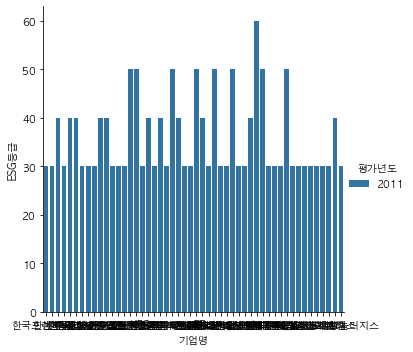

In [26]:
import seaborn as sns
plt.figure(figsize=(100,100))
sns.catplot(x="기업명", y="ESG등급",
                hue="평가년도",
                data=df_esg.tail(50), kind="bar")

In [115]:
#기업들의 년도별 각 계정과목들을 변수로 만들어줍니다
df_f = ["당기순이익.xlsx","자산총계.xlsx","매출액.xlsx","재고자산.xlsx","유보액_총자산.xlsx","비유동부채.xlsx","유동부채.xlsx","유동자산.xlsx"]

def change_columns(df):
    columns = ["종목코드","기업명","결산월","단위","2019","2018","2017","2016","2015","2014","2013","2012","2011","2010","2009","2008"]
    df.columns = columns
    df = df.rename(columns = {"종목코드":"기업코드"})
    return df

for i in range(1,9):
    setattr(mod, 'df_balance_{}'.format(i), change_columns(pd.read_excel(df_f[i-1])[9:]))
    

<Figure size 3600x5040 with 0 Axes>

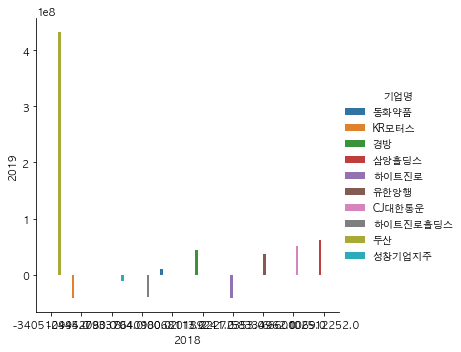

In [116]:
plt.figure(figsize=(50,70))
sns.catplot(x="2018", y="2019",
                hue="기업명",
                data=df_balance_1.head(10), kind="bar")

In [117]:
#각 년도별 기업들의 신용평가 점수, esg점수, 계정과목을 리스트에 담아놓았습니다 
list_credit = [df_credit_2013,df_credit_2014,df_credit_2015,df_credit_2016,df_credit_2017,
             df_credit_2018,df_credit_2019]

list_esg = [df_esg_2011,df_esg_2012,df_esg_2013,df_esg_2014,df_esg_2015,df_esg_2016,
            df_esg_2017,df_esg_2018,df_esg_2019]

# 순서대로 당기순이익,자산총계,매출액,재고자산,유보액총자산","비유동부채",유동부채,유동자산
list_balance = [df_balance_1,df_balance_2,df_balance_3,df_balance_4,df_balance_5,
               df_balance_6,df_balance_7,df_balance_8,]

In [119]:
#기업명만 있는 신용평가 데이터를 ESG데이터에 기업명이 같은 데이터로만 병합를 시킵니다
def merge_code(dfa,dfb):
    dfb = dfb[["기업코드","기업명"]][dfb["기업명"].isin(dfa["기업명"])]
    dfa = pd.merge(dfa,dfb, on="기업명",how="inner")
    return dfa

for i in range(2013,2020):
    setattr(mod, 'df_rating_{}'.format(i), merge_code(list_credit[i-2013],list_esg[i-2013]))

# 그 후 각 년도별 계정 데이터프레임에 있는 기업들 중 신용평가 점수와 esg점수가 있는 기업별로 묶어줍니다
for k in range(2011, 2020):
    for i in range(1,9):
        setattr(mod, 'df_{}_{}'.format(k,i), pd.DataFrame(list_balance[i-1].iloc[:,[0,2023-k]]))


In [126]:
#각 재무재표 계정명들을 기업코드를 기준으로 합병 시켜줍니다
df_columns = ["기업코드","당기순이익","자산총계","매출액","재고자산","유보액_총자산","비유동부채","유동부채","유동자산"]

data_frames_2011 = [df_2011_1,df_2011_2,df_2011_3,df_2011_4,df_2011_5,df_2011_6,df_2011_7,df_2011_8,]#df_2011_9,df_2011_10,df_2011_11,]
data_frames_2012 = [df_2012_1,df_2012_2,df_2012_3,df_2012_4,df_2012_5,df_2012_6,df_2012_7,df_2012_8,]#df_2012_9,df_2012_10,df_2012_11,]
data_frames_2013 = [df_2013_1,df_2013_2,df_2013_3,df_2013_4,df_2013_5,df_2013_6,df_2013_7,df_2013_8,]#df_2013_9,df_2013_10,df_2013_11,]
data_frames_2014 = [df_2014_1,df_2014_2,df_2014_3,df_2014_4,df_2014_5,df_2014_6,df_2014_7,df_2014_8,]#df_2014_9,df_2014_10,df_2014_11,]
data_frames_2015 = [df_2015_1,df_2015_2,df_2015_3,df_2015_4,df_2015_5,df_2015_6,df_2015_7,df_2015_8,]#df_2015_9,df_2015_10,df_2015_11,]
data_frames_2016 = [df_2016_1,df_2016_2,df_2016_3,df_2016_4,df_2016_5,df_2016_6,df_2016_7,df_2016_8,]#df_2016_9,df_2016_10,df_2016_11,]
data_frames_2017 = [df_2017_1,df_2017_2,df_2017_3,df_2017_4,df_2017_5,df_2017_6,df_2017_7,df_2017_8,]#df_2017_9,df_2017_10,df_2017_11,]
data_frames_2018 = [df_2018_1,df_2018_2,df_2018_3,df_2018_4,df_2018_5,df_2018_6,df_2018_7,df_2018_8,]#df_2018_9,df_2018_10,df_2018_11,]
data_frames_2019 = [df_2019_1,df_2019_2,df_2019_3,df_2019_4,df_2019_5,df_2019_6,df_2019_7,df_2019_8,]#df_2019_9,df_2019_10,df_2019_11,]


def merge(a):
    a=reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2012).dropna()
    a=df_columns
merge_list=[data_frames_2011,data_frames_2012,data_frames_2013,data_frames_2014,data_frames_2015,
        data_frames_2016,data_frames_2017,data_frames_2018,data_frames_2019]
def merge_apply(a):
    for i in merge_list
        merge(i)
# merge(data_frames_2011)
# merge(data_frames_2012)
# merge(data_frames_2013)
# merge(data_frames_2014)
# merge(data_frames_2015)
# merge(data_frames_2016)
# merge(data_frames_2017)
# merge(data_frames_2018)
# merge(data_frames_2019)


In [57]:
# df_m = pd.read_excel("매출채권회전율.xlsx").rename(columns={"name":"기업명"})
# df_m["매출채권회전율"] = df_m["매출채권회전율"].apply(lambda x : np.reciprocal(x))
# for i in range(2011,2020):
#         setattr(mod, 'df_m_{}'.format(i), df_m[df_m["DATE"]==i].replace("(주)","").dropna())
# df_m_2011.head()

,Unnamed: 0,기업명,DATE,매출채권회전율
9,0,강남제비스코,2011,0.202332
18,0,강원랜드,2011,0.003415
45,0,경동나비엔,2011,0.091347
58,0,경동인베스트,2011,0.156648
67,0,경방,2011,0.091764


In [58]:
# m_list = [df_m_2011, df_m_2012, df_m_2013, df_m_2014, df_m_2015, df_m_2016, df_m_2017, df_m_2018, df_m_2019,]

In [59]:
#  for i in range(2011,2020):
#         setattr(mod, 'df_m_{}'.format(i), pd.merge(m_list[i-2011], df_balance_2, on="기업명", how="inner").drop_duplicates(['기업명'],keep="last").reset_index(drop=True).iloc[:,3:5] )

In [60]:
# merged_list = [df_merged_2011,df_merged_2012,df_merged_2013,df_merged_2014,df_merged_2015,df_merged_2016,df_merged_2017,df_merged_2018,df_merged_2019]

In [61]:
# m_list = [df_m_2011, df_m_2012, df_m_2013, df_m_2014, df_m_2015, df_m_2016, df_m_2017, df_m_2018, df_m_2019,]

In [62]:
# for i in range(2011,2020):
#          setattr(mod, 'df_merged_{}'.format(i), pd.merge(m_list[i-2011], merged_list[i-2011], on='기업코드', how='inner'))

In [128]:
df_ls = [df_merged_2011, df_merged_2012, df_merged_2013, df_merged_2014,\
        df_merged_2015, df_merged_2016, df_merged_2017, df_merged_2018,\
        df_merged_2019]

In [131]:
def test(df):
    df["부채총계"] = df["유동부채"] + df["비유동부채"]
    df["운전자본"] = df_merged_2011["유동자산"] - df["유동부채"]
    df["당기순이익_총자산"] = df["당기순이익"] / df["자산총계"]
    df["부채총계_총자산"] = df["부채총계"] / df["자산총계"]
    df["운전자본_총자산"] = df["운전자본"] / df["자산총계"]
    df["유동자산_총자산"] = df["유동자산"] / df["자산총계"]
    df["매출액_총자산"] = df["매출액"] / df["자산총계"]
    df["재고자산_총자산"] = df["재고자산"] / df["자산총계"]
    df["매출채권_총자산"] = (df["매출채권회전율"] * df["매출액"])/ df["자산총계"]
    return df

def test2 ():
    for df in df_ls:
        test(df)

In [ ]:
# df_merged_2011["부채총계"] = df_merged_2011["유동부채"] + df_merged_2011["비유동부채"]
# df_merged_2011["운전자본"] = df_merged_2011["유동자산"] - df_merged_2011["유동부채"]
# df_merged_2011["당기순이익_총자산"] = df_merged_2011["당기순이익"] / df_merged_2011["자산총계"]
# df_merged_2011["부채총계_총자산"] = df_merged_2011["부채총계"] / df_merged_2011["자산총계"]
# df_merged_2011["운전자본_총자산"] = df_merged_2011["운전자본"] / df_merged_2011["자산총계"]
# df_merged_2011["유동자산_총자산"] = df_merged_2011["유동자산"] / df_merged_2011["자산총계"]
# df_merged_2011["매출액_총자산"] = df_merged_2011["매출액"] / df_merged_2011["자산총계"]
# df_merged_2011["재고자산_총자산"] = df_merged_2011["재고자산"] / df_merged_2011["자산총계"]
# df_merged_2011["매출채권_총자산"] = (df_merged_2011["매출채권회전율"] * df_merged_2011["매출액"])/ df_merged_2011["자산총계"]

# df_merged_2012["부채총계"] = df_merged_2012["유동부채"] + df_merged_2012["비유동부채"]
# df_merged_2012["운전자본"] = df_merged_2012["유동자산"] - df_merged_2012["유동부채"]
# df_merged_2012["당기순이익_총자산"] = df_merged_2012["당기순이익"] / df_merged_2012["자산총계"]
# df_merged_2012["부채총계_총자산"] = df_merged_2012["부채총계"] / df_merged_2012["자산총계"]
# df_merged_2012["운전자본_총자산"] = df_merged_2012["운전자본"] / df_merged_2012["자산총계"]
# df_merged_2012["유동자산_총자산"] = df_merged_2012["유동자산"] / df_merged_2012["자산총계"]
# df_merged_2012["매출액_총자산"] = df_merged_2012["매출액"] / df_merged_2012["자산총계"]
# df_merged_2012["재고자산_총자산"] = df_merged_2012["재고자산"] / df_merged_2012["자산총계"]
# df_merged_2012["매출채권_총자산"] = (df_merged_2012["매출채권회전율"] * df_merged_2012["매출액"])/ df_merged_2012["자산총계"]

# df_merged_2013["부채총계"] = df_merged_2013["유동부채"] + df_merged_2013["비유동부채"]
# df_merged_2013["운전자본"] = df_merged_2013["유동자산"] - df_merged_2013["유동부채"]
# df_merged_2013["당기순이익_총자산"] = df_merged_2013["당기순이익"] / df_merged_2013["자산총계"]
# df_merged_2013["부채총계_총자산"] = df_merged_2013["부채총계"] / df_merged_2013["자산총계"]
# df_merged_2013["운전자본_총자산"] = df_merged_2013["운전자본"] / df_merged_2013["자산총계"]
# df_merged_2013["유동자산_총자산"] = df_merged_2013["유동자산"] / df_merged_2013["자산총계"]
# df_merged_2013["매출액_총자산"] = df_merged_2013["매출액"] / df_merged_2013["자산총계"]
# df_merged_2013["재고자산_총자산"] = df_merged_2013["재고자산"] / df_merged_2013["자산총계"]
# df_merged_2013["매출채권_총자산"] = (df_merged_2013["매출채권회전율"] * df_merged_2013["매출액"])/ df_merged_2013["자산총계"]

# df_merged_2014["부채총계"] = df_merged_2014["유동부채"] + df_merged_2014["비유동부채"]
# df_merged_2014["운전자본"] = df_merged_2014["유동자산"] - df_merged_2014["유동부채"]
# df_merged_2014["당기순이익_총자산"] = df_merged_2014["당기순이익"] / df_merged_2014["자산총계"]
# df_merged_2014["부채총계_총자산"] = df_merged_2014["부채총계"] / df_merged_2014["자산총계"]
# df_merged_2014["운전자본_총자산"] = df_merged_2014["운전자본"] / df_merged_2014["자산총계"]
# df_merged_2014["유동자산_총자산"] = df_merged_2014["유동자산"] / df_merged_2014["자산총계"]
# df_merged_2014["매출액_총자산"] = df_merged_2014["매출액"] / df_merged_2014["자산총계"]
# df_merged_2014["재고자산_총자산"] = df_merged_2014["재고자산"] / df_merged_2014["자산총계"]
# df_merged_2014["매출채권_총자산"] = (df_merged_2014["매출채권회전율"] * df_merged_2014["매출액"])/ df_merged_2014["자산총계"]

# df_merged_2015["부채총계"] = df_merged_2015["유동부채"] + df_merged_2015["비유동부채"]
# df_merged_2015["운전자본"] = df_merged_2015["유동자산"] - df_merged_2015["유동부채"]
# df_merged_2015["당기순이익_총자산"] = df_merged_2015["당기순이익"] / df_merged_2015["자산총계"]
# df_merged_2015["부채총계_총자산"] = df_merged_2015["부채총계"] / df_merged_2015["자산총계"]
# df_merged_2015["운전자본_총자산"] = df_merged_2015["운전자본"] / df_merged_2015["자산총계"]
# df_merged_2015["유동자산_총자산"] = df_merged_2015["유동자산"] / df_merged_2015["자산총계"]
# df_merged_2015["매출액_총자산"] = df_merged_2015["매출액"] / df_merged_2015["자산총계"]
# df_merged_2015["재고자산_총자산"] = df_merged_2015["재고자산"] / df_merged_2015["자산총계"]
# df_merged_2015["매출채권_총자산"] = (df_merged_2015["매출채권회전율"] * df_merged_2015["매출액"])/ df_merged_2015["자산총계"]

# df_merged_2016["부채총계"] = df_merged_2016["유동부채"] + df_merged_2016["비유동부채"]
# df_merged_2016["운전자본"] = df_merged_2016["유동자산"] - df_merged_2016["유동부채"]
# df_merged_2016["당기순이익_총자산"] = df_merged_2016["당기순이익"] / df_merged_2016["자산총계"]
# df_merged_2016["부채총계_총자산"] = df_merged_2016["부채총계"] / df_merged_2016["자산총계"]
# df_merged_2016["운전자본_총자산"] = df_merged_2016["운전자본"] / df_merged_2016["자산총계"]
# df_merged_2016["유동자산_총자산"] = df_merged_2016["유동자산"] / df_merged_2016["자산총계"]
# df_merged_2016["매출액_총자산"] = df_merged_2016["매출액"] / df_merged_2016["자산총계"]
# df_merged_2016["재고자산_총자산"] = df_merged_2016["재고자산"] / df_merged_2016["자산총계"]
# df_merged_2016["매출채권_총자산"] = (df_merged_2016["매출채권회전율"] * df_merged_2016["매출액"])/ df_merged_2016["자산총계"]

# df_merged_2017["부채총계"] = df_merged_2017["유동부채"] + df_merged_2017["비유동부채"]
# df_merged_2017["운전자본"] = df_merged_2017["유동자산"] - df_merged_2017["유동부채"]
# df_merged_2017["당기순이익_총자산"] = df_merged_2017["당기순이익"] / df_merged_2017["자산총계"]
# df_merged_2017["부채총계_총자산"] = df_merged_2017["부채총계"] / df_merged_2017["자산총계"]
# df_merged_2017["운전자본_총자산"] = df_merged_2017["운전자본"] / df_merged_2017["자산총계"]
# df_merged_2017["유동자산_총자산"] = df_merged_2017["유동자산"] / df_merged_2017["자산총계"]
# df_merged_2017["매출액_총자산"] = df_merged_2017["매출액"] / df_merged_2017["자산총계"]
# df_merged_2017["재고자산_총자산"] = df_merged_2017["재고자산"] / df_merged_2017["자산총계"]
# df_merged_2017["매출채권_총자산"] = (df_merged_2017["매출채권회전율"] * df_merged_2017["매출액"])/ df_merged_2017["자산총계"]

# df_merged_2018["부채총계"] = df_merged_2018["유동부채"] + df_merged_2018["비유동부채"]
# df_merged_2018["운전자본"] = df_merged_2018["유동자산"] - df_merged_2018["유동부채"]
# df_merged_2018["당기순이익_총자산"] = df_merged_2018["당기순이익"] / df_merged_2018["자산총계"]
# df_merged_2018["부채총계_총자산"] = df_merged_2018["부채총계"] / df_merged_2018["자산총계"]
# df_merged_2018["운전자본_총자산"] = df_merged_2018["운전자본"] / df_merged_2018["자산총계"]
# df_merged_2018["유동자산_총자산"] = df_merged_2018["유동자산"] / df_merged_2018["자산총계"]
# df_merged_2018["매출액_총자산"] = df_merged_2018["매출액"] / df_merged_2018["자산총계"]
# df_merged_2018["재고자산_총자산"] = df_merged_2018["재고자산"] / df_merged_2018["자산총계"]
# df_merged_2018["매출채권_총자산"] = (df_merged_2018["매출채권회전율"] * df_merged_2018["매출액"])/ df_merged_2018["자산총계"]

# df_merged_2019["부채총계"] = df_merged_2019["유동부채"] + df_merged_2019["비유동부채"]
# df_merged_2019["운전자본"] = df_merged_2019["유동자산"] - df_merged_2019["유동부채"]
# df_merged_2019["당기순이익_총자산"] = df_merged_2019["당기순이익"] / df_merged_2019["자산총계"]
# df_merged_2019["부채총계_총자산"] = df_merged_2019["부채총계"] / df_merged_2019["자산총계"]
# df_merged_2019["운전자본_총자산"] = df_merged_2019["운전자본"] / df_merged_2019["자산총계"]
# df_merged_2019["유동자산_총자산"] = df_merged_2019["유동자산"] / df_merged_2019["자산총계"]
# df_merged_2019["매출액_총자산"] = df_merged_2019["매출액"] / df_merged_2019["자산총계"]
# df_merged_2019["재고자산_총자산"] = df_merged_2019["재고자산"] / df_merged_2019["자산총계"]
# df_merged_2019["매출채권_총자산"] = (df_merged_2019["매출채권회전율"] * df_merged_2019["매출액"])/ df_merged_2019["자산총계"]

In [140]:

    
data_frames_a_2011 = [df_merged_2011,df_esg_2011]
df_merged_b_2011 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2011).dropna()

data_frames_a_2012 = [df_merged_2012,df_esg_2012]
df_merged_b_2012 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2012).dropna()

data_frames_a_2013 = [df_merged_2013,df_esg_2013]
df_merged_b_2013 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2013).dropna()

data_frames_a_2014 = [df_merged_2014,df_esg_2014]
df_merged_b_2014 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2014).dropna()

data_frames_a_2015 = [df_merged_2015,df_esg_2015]
df_merged_b_2015 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2015).dropna()

data_frames_a_2016 = [df_merged_2016,df_esg_2016]
df_merged_b_2016 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2016).dropna()

data_frames_a_2017 = [df_merged_2017,df_esg_2017]
df_merged_b_2017 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2017).dropna()

data_frames_a_2018 = [df_merged_2018,df_esg_2018]
df_merged_b_2018 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2018).dropna()

data_frames_a_2019 = [df_merged_2019,df_esg_2019]
df_merged_b_2019 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2019).dropna()

In [141]:
df_merged_list=[df_merged_b_2011,df_merged_b_2012,df_merged_b_2013,df_merged_b_2014,
                df_merged_b_2015,df_merged_b_2016,df_merged_b_2017,df_merged_b_2018,df_merged_b_2019]
def df_merged_iloc(a):
    a=a.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]
def apply_iloc(a):
    for a in df_merged_list:
        df_merge_iloc(a)


# df_merged_b_2011 = df_merged_b_2011.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2012 = df_merged_b_2012.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2013 = df_merged_b_2013.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2014 = df_merged_b_2014.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2015 = df_merged_b_2015.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2016 = df_merged_b_2016.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2017 = df_merged_b_2017.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2018 = df_merged_b_2018.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_b_2019 = df_merged_b_2019.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
# df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
# df_merged_z_2012 = df_merged_b_2012[df_merged_b_2012["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
# df_merged_z_2011 = df_merged_b_2011[df_merged_b_2011["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
# df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)

In [142]:
len(df_merged_list)

9

In [ ]:
def df_merged_z(a=df_merged_list):
    for i in df_merged_list
        if i == 7:
            break
        df_merged_list[i+2]=a[a[]]
         = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)


In [ ]:
print(len(df_merged_z_2014))
print(len(df_merged_z_2013))
print(len(df_merged_z_2012))

In [ ]:
df_merged_b_2014.columns

In [ ]:
df_merged_c_2014 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2014["기업코드"] = df_merged_z_2014["기업코드"]
# df_merged_c_2014['자산총계'] = ((df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2 -(df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2)
df_merged_c_2014['유보액_총자산'] = ((df_merged_z_2014['유보액_총자산'] + df_merged_z_2013['유보액_총자산'])/2 -(df_merged_z_2013['유보액_총자산'] + df_merged_z_2012['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['유보액_총자산'] + df_merged_z_2012['유보액_총자산'])/2)
df_merged_c_2014['당기순이익_총자산'] = ((df_merged_z_2014['당기순이익_총자산'] + df_merged_z_2013['당기순이익_총자산'])/2 -(df_merged_z_2013['당기순이익_총자산'] + df_merged_z_2012['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['당기순이익_총자산'] + df_merged_z_2012['당기순이익_총자산'])/2)
df_merged_c_2014['부채총계_총자산'] = ((df_merged_z_2014['부채총계_총자산'] + df_merged_z_2013['부채총계_총자산'])/2 -(df_merged_z_2013['부채총계_총자산'] + df_merged_z_2012['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['부채총계_총자산'] + df_merged_z_2012['부채총계_총자산'])/2)
df_merged_c_2014['운전자본_총자산'] = ((df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2 -(df_merged_z_2013['운전자본_총자산'] + df_merged_z_2012['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['운전자본_총자산'] + df_merged_z_2012['운전자본_총자산'])/2)
df_merged_c_2014['매출액_총자산'] = ((df_merged_z_2014['매출액_총자산'] + df_merged_z_2013['매출액_총자산'])/2 -(df_merged_z_2013['매출액_총자산'] + df_merged_z_2012['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['매출액_총자산'] + df_merged_z_2012['매출액_총자산'])/2)
df_merged_c_2014['재고자산_총자산'] = ((df_merged_z_2014['재고자산_총자산'] + df_merged_z_2013['재고자산_총자산'])/2 -(df_merged_z_2013['재고자산_총자산'] + df_merged_z_2012['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['재고자산_총자산'] + df_merged_z_2012['재고자산_총자산'])/2)
df_merged_c_2014['유동자산_총자산'] = ((df_merged_z_2014['유동자산_총자산'] + df_merged_z_2013['유동자산_총자산'])/2 -(df_merged_z_2013['유동자산_총자산'] + df_merged_z_2012['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['유동자산_총자산'] + df_merged_z_2012['유동자산_총자산'])/2)
df_merged_c_2014['매출채권_총자산'] = ((df_merged_z_2014['매출채권_총자산'] + df_merged_z_2013['매출채권_총자산'])/2 -(df_merged_z_2013['매출채권_총자산'] + df_merged_z_2012['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['매출채권_총자산'] + df_merged_z_2012['매출채권_총자산'])/2)
df_merged_c_2014['ESG등급'] = (df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2 -  (df_merged_z_2013['ESG등급'] + df_merged_z_2012['ESG등급'])/2
df_merged_c_2014['지배구조'] = (df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2 - (df_merged_z_2013['지배구조'] + df_merged_z_2012['지배구조'])/2
df_merged_c_2014['사회'] = (df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2 - (df_merged_z_2013['사회'] + df_merged_z_2012['사회'])/2
df_merged_c_2014['환경'] = (df_merged_z_2014['환경'] + df_merged_z_2013['환경'])/2 - (df_merged_z_2013['환경'] +df_merged_z_2012['환경'])/2

In [ ]:
df_total_2015 = pd.merge(df_rating_2015,df_merged_c_2014.dropna(), on="기업코드", how="inner")

In [ ]:
df_total_2015.describe()

In [ ]:
# df_kospi_2015 = df_total_2015[df_total_2015["기업코드"].isin(kospi_2015)]

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.boxplot(
    data=df_total_2015,
    x='평가등급',
    y='ESG등급',
    color='red')

In [ ]:
df_merged_c_2015 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2015["기업코드"] = df_merged_z_2015["기업코드"]
# df_merged_c_2015['자산총계'] = ((df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2 -(df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2)
df_merged_c_2015['유보액_총자산'] = ((df_merged_z_2015['유보액_총자산'] + df_merged_z_2014['유보액_총자산'])/2 -(df_merged_z_2014['유보액_총자산'] + df_merged_z_2013['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['유보액_총자산'] + df_merged_z_2013['유보액_총자산'])/2)
df_merged_c_2015['당기순이익_총자산'] = ((df_merged_z_2015['당기순이익_총자산'] + df_merged_z_2014['당기순이익_총자산'])/2 -(df_merged_z_2014['당기순이익_총자산'] + df_merged_z_2013['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['당기순이익_총자산'] + df_merged_z_2013['당기순이익_총자산'])/2)
df_merged_c_2015['부채총계_총자산'] = ((df_merged_z_2015['부채총계_총자산'] + df_merged_z_2014['부채총계_총자산'])/2 -(df_merged_z_2014['부채총계_총자산'] + df_merged_z_2013['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['부채총계_총자산'] + df_merged_z_2013['부채총계_총자산'])/2)
df_merged_c_2015['운전자본_총자산'] = ((df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2 -(df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2)
df_merged_c_2015['매출액_총자산'] = ((df_merged_z_2015['매출액_총자산'] + df_merged_z_2014['매출액_총자산'])/2 -(df_merged_z_2014['매출액_총자산'] + df_merged_z_2013['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['매출액_총자산'] + df_merged_z_2013['매출액_총자산'])/2)
df_merged_c_2015['재고자산_총자산'] = ((df_merged_z_2015['재고자산_총자산'] + df_merged_z_2014['재고자산_총자산'])/2 -(df_merged_z_2014['재고자산_총자산'] + df_merged_z_2013['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['재고자산_총자산'] + df_merged_z_2013['재고자산_총자산'])/2)
df_merged_c_2015['유동자산_총자산'] = ((df_merged_z_2015['유동자산_총자산'] + df_merged_z_2014['유동자산_총자산'])/2 -(df_merged_z_2014['유동자산_총자산'] + df_merged_z_2013['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['유동자산_총자산'] + df_merged_z_2013['유동자산_총자산'])/2)
df_merged_c_2015['매출채권_총자산'] = ((df_merged_z_2015['매출채권_총자산'] + df_merged_z_2014['매출채권_총자산'])/2 -(df_merged_z_2014['매출채권_총자산'] + df_merged_z_2013['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['매출채권_총자산'] + df_merged_z_2013['매출채권_총자산'])/2)
df_merged_c_2015['ESG등급'] = (df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2 -  (df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2
df_merged_c_2015['지배구조'] = (df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2 - (df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2
df_merged_c_2015['사회'] = (df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2 - (df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2
df_merged_c_2015['환경'] = (df_merged_z_2015['환경'] + df_merged_z_2014['환경'])/2 - (df_merged_z_2014['환경'] +df_merged_z_2013['환경'])/2

In [ ]:
df_total_2016 = pd.merge(df_rating_2016,df_merged_c_2015.dropna(), on="기업코드", how="inner")

In [ ]:
df_total_2016.describe()

In [ ]:
# df_kospi_2016 = df_total_2016[df_total_2016["기업코드"].isin(kospi_2016)]

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.boxplot(
    data=df_total_2016,
    x='평가등급',
    y='ESG등급',
    color='red')

In [ ]:
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [ ]:
df_merged_c_2016 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2016["기업코드"] = df_merged_z_2016["기업코드"]
# df_merged_c_2016['자산총계'] = ((df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2 -(df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2)
df_merged_c_2016['유보액_총자산'] = ((df_merged_z_2016['유보액_총자산'] + df_merged_z_2015['유보액_총자산'])/2 -(df_merged_z_2015['유보액_총자산'] + df_merged_z_2014['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['유보액_총자산'] + df_merged_z_2014['유보액_총자산'])/2)
df_merged_c_2016['당기순이익_총자산'] = ((df_merged_z_2016['당기순이익_총자산'] + df_merged_z_2015['당기순이익_총자산'])/2 -(df_merged_z_2015['당기순이익_총자산'] + df_merged_z_2014['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['당기순이익_총자산'] + df_merged_z_2014['당기순이익_총자산'])/2)
df_merged_c_2016['부채총계_총자산'] = ((df_merged_z_2016['부채총계_총자산'] + df_merged_z_2015['부채총계_총자산'])/2 -(df_merged_z_2015['부채총계_총자산'] + df_merged_z_2014['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['부채총계_총자산'] + df_merged_z_2014['부채총계_총자산'])/2)
df_merged_c_2016['운전자본_총자산'] = ((df_merged_z_2016['운전자본_총자산'] + df_merged_z_2015['운전자본_총자산'])/2 -(df_merged_z_2015['운전자본_총자산'] + df_merged_z_2014['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['운전자본_총자산'] + df_merged_z_2014['운전자본_총자산'])/2)
df_merged_c_2016['매출액_총자산'] = ((df_merged_z_2016['매출액_총자산'] + df_merged_z_2015['매출액_총자산'])/2 -(df_merged_z_2015['매출액_총자산'] + df_merged_z_2014['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['매출액_총자산'] + df_merged_z_2014['매출액_총자산'])/2)
df_merged_c_2016['재고자산_총자산'] = ((df_merged_z_2016['재고자산_총자산'] + df_merged_z_2015['재고자산_총자산'])/2 -(df_merged_z_2015['재고자산_총자산'] + df_merged_z_2014['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['재고자산_총자산'] + df_merged_z_2014['재고자산_총자산'])/2)
df_merged_c_2016['유동자산_총자산'] = ((df_merged_z_2016['유동자산_총자산'] + df_merged_z_2015['유동자산_총자산'])/2 -(df_merged_z_2015['유동자산_총자산'] + df_merged_z_2014['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['유동자산_총자산'] + df_merged_z_2014['유동자산_총자산'])/2)
df_merged_c_2016['매출채권_총자산'] = ((df_merged_z_2016['매출채권_총자산'] + df_merged_z_2015['매출채권_총자산'])/2 -(df_merged_z_2015['매출채권_총자산'] + df_merged_z_2014['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['매출채권_총자산'] + df_merged_z_2014['매출채권_총자산'])/2)
df_merged_c_2016['ESG등급'] = (df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2 -  (df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2
df_merged_c_2016['지배구조'] = (df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2 - (df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2
df_merged_c_2016['사회'] = (df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2 - (df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2
df_merged_c_2016['환경'] = (df_merged_z_2016['환경'] + df_merged_z_2015['환경'])/2 - (df_merged_z_2015['환경'] +df_merged_z_2014['환경'])/2

In [ ]:
df_total_2017 = pd.merge(df_rating_2017,df_merged_c_2016.dropna(), on="기업코드", how="inner")

In [ ]:
df_total_2017.describe()

In [ ]:
# df_kospi_2017 = df_total_2017[df_total_2017["기업코드"].isin(kospi_2017)]

In [ ]:
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [ ]:
df_merged_c_2017 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2017["기업코드"] = df_merged_z_2017["기업코드"]
# df_merged_c_2017['자산총계'] = ((df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2 -(df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2)
df_merged_c_2017['유보액_총자산'] = ((df_merged_z_2017['유보액_총자산'] + df_merged_z_2016['유보액_총자산'])/2 -(df_merged_z_2016['유보액_총자산'] + df_merged_z_2015['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['유보액_총자산'] + df_merged_z_2015['유보액_총자산'])/2)
df_merged_c_2017['당기순이익_총자산'] = ((df_merged_z_2017['당기순이익_총자산'] + df_merged_z_2016['당기순이익_총자산'])/2 -(df_merged_z_2016['당기순이익_총자산'] + df_merged_z_2015['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['당기순이익_총자산'] + df_merged_z_2015['당기순이익_총자산'])/2)
df_merged_c_2017['부채총계_총자산'] = ((df_merged_z_2017['부채총계_총자산'] + df_merged_z_2016['부채총계_총자산'])/2 -(df_merged_z_2016['부채총계_총자산'] + df_merged_z_2015['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['부채총계_총자산'] + df_merged_z_2015['부채총계_총자산'])/2)
df_merged_c_2017['운전자본_총자산'] = ((df_merged_z_2017['운전자본_총자산'] + df_merged_z_2016['운전자본_총자산'])/2 -(df_merged_z_2016['운전자본_총자산'] + df_merged_z_2015['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['운전자본_총자산'] + df_merged_z_2015['운전자본_총자산'])/2)
df_merged_c_2017['매출액_총자산'] = ((df_merged_z_2017['매출액_총자산'] + df_merged_z_2016['매출액_총자산'])/2 -(df_merged_z_2016['매출액_총자산'] + df_merged_z_2015['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['매출액_총자산'] + df_merged_z_2015['매출액_총자산'])/2)
df_merged_c_2017['재고자산_총자산'] = ((df_merged_z_2017['재고자산_총자산'] + df_merged_z_2016['재고자산_총자산'])/2 -(df_merged_z_2016['재고자산_총자산'] + df_merged_z_2015['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['재고자산_총자산'] + df_merged_z_2015['재고자산_총자산'])/2)
df_merged_c_2017['유동자산_총자산'] = ((df_merged_z_2017['유동자산_총자산'] + df_merged_z_2016['유동자산_총자산'])/2 -(df_merged_z_2016['유동자산_총자산'] + df_merged_z_2015['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['유동자산_총자산'] + df_merged_z_2015['유동자산_총자산'])/2)
df_merged_c_2017['매출채권_총자산'] = ((df_merged_z_2017['매출채권_총자산'] + df_merged_z_2016['매출채권_총자산'])/2 -(df_merged_z_2016['매출채권_총자산'] + df_merged_z_2015['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['매출채권_총자산'] + df_merged_z_2015['매출채권_총자산'])/2)
df_merged_c_2017['ESG등급'] = (df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2 -  (df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2
df_merged_c_2017['지배구조'] = (df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2 - (df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2
df_merged_c_2017['사회'] = (df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2 - (df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2
df_merged_c_2017['환경'] = (df_merged_z_2017['환경'] + df_merged_z_2016['환경'])/2 - (df_merged_z_2016['환경'] +df_merged_z_2015['환경'])/2

In [ ]:
df_total_2018 = pd.merge(df_rating_2018,df_merged_c_2017.dropna(), on="기업코드", how="inner")

In [ ]:
df_total_2018.describe()

In [ ]:
# df_kospi_2018 = df_total_2018[df_total_2018["기업코드"].isin(kospi_2018)]

In [ ]:
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

In [ ]:
df_merged_c_2018 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2018["기업코드"] = df_merged_z_2018["기업코드"]
# df_merged_c_2018['자산총계'] = ((df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2 -(df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2)
df_merged_c_2018['유보액_총자산'] = ((df_merged_z_2018['유보액_총자산'] + df_merged_z_2017['유보액_총자산'])/2 -(df_merged_z_2017['유보액_총자산'] + df_merged_z_2016['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['유보액_총자산'] + df_merged_z_2016['유보액_총자산'])/2)
df_merged_c_2018['당기순이익_총자산'] = ((df_merged_z_2018['당기순이익_총자산'] + df_merged_z_2017['당기순이익_총자산'])/2 -(df_merged_z_2017['당기순이익_총자산'] + df_merged_z_2016['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['당기순이익_총자산'] + df_merged_z_2016['당기순이익_총자산'])/2)
df_merged_c_2018['부채총계_총자산'] = ((df_merged_z_2018['부채총계_총자산'] + df_merged_z_2017['부채총계_총자산'])/2 -(df_merged_z_2017['부채총계_총자산'] + df_merged_z_2016['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['부채총계_총자산'] + df_merged_z_2016['부채총계_총자산'])/2)
df_merged_c_2018['운전자본_총자산'] = ((df_merged_z_2018['운전자본_총자산'] + df_merged_z_2017['운전자본_총자산'])/2 -(df_merged_z_2017['운전자본_총자산'] + df_merged_z_2016['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['운전자본_총자산'] + df_merged_z_2016['운전자본_총자산'])/2)
df_merged_c_2018['매출액_총자산'] = ((df_merged_z_2018['매출액_총자산'] + df_merged_z_2017['매출액_총자산'])/2 -(df_merged_z_2017['매출액_총자산'] + df_merged_z_2016['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['매출액_총자산'] + df_merged_z_2016['매출액_총자산'])/2)
df_merged_c_2018['재고자산_총자산'] = ((df_merged_z_2018['재고자산_총자산'] + df_merged_z_2017['재고자산_총자산'])/2 -(df_merged_z_2017['재고자산_총자산'] + df_merged_z_2016['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['재고자산_총자산'] + df_merged_z_2016['재고자산_총자산'])/2)
df_merged_c_2018['유동자산_총자산'] = ((df_merged_z_2018['유동자산_총자산'] + df_merged_z_2017['유동자산_총자산'])/2 -(df_merged_z_2017['유동자산_총자산'] + df_merged_z_2016['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['유동자산_총자산'] + df_merged_z_2016['유동자산_총자산'])/2)
df_merged_c_2018['매출채권_총자산'] = ((df_merged_z_2018['매출채권_총자산'] + df_merged_z_2017['매출채권_총자산'])/2 -(df_merged_z_2017['매출채권_총자산'] + df_merged_z_2016['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['매출채권_총자산'] + df_merged_z_2016['매출채권_총자산'])/2)
df_merged_c_2018['ESG등급'] = (df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2 -  (df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2
df_merged_c_2018['지배구조'] = (df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2 - (df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2
df_merged_c_2018['사회'] = (df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2 - (df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2
df_merged_c_2018['환경'] = (df_merged_z_2018['환경'] + df_merged_z_2017['환경'])/2 - (df_merged_z_2017['환경'] +df_merged_z_2016['환경'])/2

In [ ]:
df_total_2019 = pd.merge(df_rating_2019,df_merged_c_2018.dropna(), on="기업코드", how="inner")

In [ ]:
# df_kospi_2019 = df_total_2019[df_total_2019["기업코드"].isin(kospi_2019)]

In [ ]:
df_merged_z_2019 = df_merged_b_2019[df_merged_b_2019["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

In [ ]:
df_merged_c_2019 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2019["기업코드"] = df_merged_z_2019["기업코드"]
# df_merged_c_2019['자산총계'] = ((df_merged_z_2019['자산총계'] + df_merged_z_2018['자산총계'])/2 -(df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2)
df_merged_c_2019['유보액_총자산'] = ((df_merged_z_2019['유보액_총자산'] + df_merged_z_2018['유보액_총자산'])/2 -(df_merged_z_2018['유보액_총자산'] + df_merged_z_2017['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['유보액_총자산'] + df_merged_z_2017['유보액_총자산'])/2)
df_merged_c_2019['당기순이익_총자산'] = ((df_merged_z_2019['당기순이익_총자산'] + df_merged_z_2018['당기순이익_총자산'])/2 -(df_merged_z_2018['당기순이익_총자산'] + df_merged_z_2017['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['당기순이익_총자산'] + df_merged_z_2017['당기순이익_총자산'])/2)
df_merged_c_2019['부채총계_총자산'] = ((df_merged_z_2019['부채총계_총자산'] + df_merged_z_2018['부채총계_총자산'])/2 -(df_merged_z_2018['부채총계_총자산'] + df_merged_z_2017['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['부채총계_총자산'] + df_merged_z_2017['부채총계_총자산'])/2)
df_merged_c_2019['운전자본_총자산'] = ((df_merged_z_2019['운전자본_총자산'] + df_merged_z_2018['운전자본_총자산'])/2 -(df_merged_z_2018['운전자본_총자산'] + df_merged_z_2017['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['운전자본_총자산'] + df_merged_z_2017['운전자본_총자산'])/2)
df_merged_c_2019['매출액_총자산'] = ((df_merged_z_2019['매출액_총자산'] + df_merged_z_2018['매출액_총자산'])/2 -(df_merged_z_2018['매출액_총자산'] + df_merged_z_2017['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['매출액_총자산'] + df_merged_z_2017['매출액_총자산'])/2)
df_merged_c_2019['재고자산_총자산'] = ((df_merged_z_2019['재고자산_총자산'] + df_merged_z_2018['재고자산_총자산'])/2 -(df_merged_z_2018['재고자산_총자산'] + df_merged_z_2017['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['재고자산_총자산'] + df_merged_z_2017['재고자산_총자산'])/2)
df_merged_c_2019['유동자산_총자산'] = ((df_merged_z_2019['유동자산_총자산'] + df_merged_z_2018['유동자산_총자산'])/2 -(df_merged_z_2018['유동자산_총자산'] + df_merged_z_2017['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['유동자산_총자산'] + df_merged_z_2017['유동자산_총자산'])/2)
df_merged_c_2019['매출채권_총자산'] = ((df_merged_z_2019['매출채권_총자산'] + df_merged_z_2018['매출채권_총자산'])/2 -(df_merged_z_2018['매출채권_총자산'] + df_merged_z_2017['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['매출채권_총자산'] + df_merged_z_2017['매출채권_총자산'])/2)
df_merged_c_2019['ESG등급'] = (df_merged_z_2019['ESG등급'] + df_merged_z_2018['ESG등급'])/2 -  (df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2
df_merged_c_2019['지배구조'] = (df_merged_z_2019['지배구조'] + df_merged_z_2018['지배구조'])/2 - (df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2
df_merged_c_2019['사회'] = (df_merged_z_2019['사회'] + df_merged_z_2018['사회'])/2 - (df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2
df_merged_c_2019['환경'] = (df_merged_z_2019['환경'] + df_merged_z_2018['환경'])/2 - (df_merged_z_2018['환경'] +df_merged_z_2017['환경'])/2

In [ ]:
df_rating_2020 = merge_code(df_credit_2020, df_esg_2019)

In [ ]:
df_total_2020 = pd.merge(df_rating_2020,df_merged_c_2019.dropna(), on="기업코드", how="inner")

In [ ]:
df_total_2020.describe()

In [ ]:
# df_kospi_2020 = df_total_2020[df_total_2020["기업코드"].isin(kospi_2020)]

In [ ]:
df_sum_2015_2020 = pd.concat([df_total_2015,df_total_2016,df_total_2017,df_total_2018,df_total_2019,df_total_2020]).replace(np.inf,np.nan).dropna()
df_sum_2015_2020 = df_sum_2015_2020.rename(columns={"유보액_총자산":"유보액_총자산"})[:]

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_sum_2015_2020.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [ ]:
# sns.pairplot(df_sum_2015_2020)
# plt.show()

In [ ]:
df_x = df_sum_2015_2020.iloc[:,5:]
df_y = df_sum_2015_2020.iloc[:,1]

In [ ]:
robust_scaler = RobustScaler()
rb = robust_scaler.fit(df_x)
output = robust_scaler.transform(df_x)
output = pd.DataFrame(output, columns=df_x.columns, index=list(df_x.index.values))
output["Y"] = df_y

In [ ]:
from sklearn.linear_model import LinearRegression
model = sm.OLS.from_formula("Y ~유보액_총자산+매출채권_총자산+당기순이익_총자산+부채총계_총자산+운전자본_총자산+유동자산_총자산+매출액_총자산+재고자산_총자산+지배구조+사회+환경+0", data=output)
result = model.fit()
print(result.summary())

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(result, fig=fig)

In [ ]:
model = sm.Logit.from_formula("Y ~유보액_총자산+매출채권_총자산+당기순이익_총자산+부채총계_총자산+운전자본_총자산+유동자산_총자산+매출액_총자산+재고자산_총자산+지배구조+사회+환경+0", data=output)
result1 = model.fit()
print(result1.summary())

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(result1, fig=fig)

## DecisionTreeClass

###  ESG통합 +E + S + G

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y,test_size=0.3)

In [ ]:
rb = robust_scaler.fit(X_train)
X_train = robust_scaler.transform(X_train)
X_test = robust_scaler.transform(X_test)

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))

In [ ]:
print(model.predict(X_test).shape)
print(y_test.shape)

In [ ]:
print(len(y_test[y_test==1].dropna()))

In [ ]:
precision_score(y_true, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0])

### 사회

In [ ]:
df_x2 = df_x.drop(columns =["ESG등급","지배구조","환경"])
X_train, X_test, y_train, y_test = train_test_split(df_x2, df_y,test_size=0.3)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print(len(y_test[y_test==1].dropna()))
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))

In [ ]:
precision_score(y_true, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0])

In [ ]:
df_x2 = df_x.drop(columns =["ESG등급","지배구조","환경"])
X_train, X_test, y_train, y_test = train_test_split(df_x2, df_y,test_size=0.3)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print(len(y_test[y_test==1].dropna()))
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))

### ESG 전체 제거

In [ ]:
df_x5 = df_x.drop(columns =["ESG등급","지배구조","환경","사회"])
X_train, X_test, y_train, y_test = train_test_split(df_x5, df_y,test_size=0.3)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))
print(len(y_test[y_test==1].dropna()))

In [ ]:
precision_score(y_true, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0])